# Implicit Recommendations

## Collaborative Filtering

Это основано на отношениях между пользователями и предметами, при этом нет никакой информации о пользователях или необходимых предметах.

Все, что вам нужно, - это какой-то рейтинг для каждого взаимодействия между пользователями и элементами, которое произошло там, где это возможно. Для этого типа взаимодействия доступны два вида данных: явные и неявные.

- Явные: Оценка, например, рейтинг.
- Неявно: Не так очевидно с точки зрения предпочтений, такие как клик, просмотр или покупка.

Наиболее часто обсуждаемый пример - рейтинги фильмов, которые даются по числовой шкале. Мы можем легко увидеть, понравился ли пользователю фильм на основе предоставленного рейтинга. Проблема, однако, в том, что в большинстве случаев люди вообще не предоставляют рейтинги, поэтому объем доступных данных весьма скуден. Netflix, по крайней мере, знает, смотрел ли я что-то, что не требует дополнительного ввода с моей стороны. Может быть так, что я что-то посмотрел, но потом мне это не понравилось. Таким образом, может быть сложнее сделать вывод, следует ли считать этот тип фильмов положительной рекомендацией или нет.

Поскольку больше данных обычно означает лучшую модель, подразумеваемая обратная связь - это то, на чем должны быть сконцентрированы наши усилия.

### Метод Чередующихся Наименьших Квадратов

Прежде чем мы начнем строить свою собственную систему рекомендаций на примере проблемы, давайте попробуем понять интуцию, как этот метод работает. Совместная фильтрация не требует никакой информации о пользователях или элементах. Есть ли другой способ выяснить, как пользователи и элементы связаны друг с другом?

Оказывается, можно, если применить матричную факторизацию. Часто матричная факторизация применяется в области уменьшения размерности, где мы пытаемся уменьшить количество элементов, сохраняя при этом соответствующую информацию. Так обстоит дело с [основным компонентным анализом](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) и очень похожим [разложение по сингулярному значению](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD).

По сути, можем ли мы взять большую матрицу взаимодействия пользователя и элемента и вычислить скрытые особенности, которые связывают их друг с другом в гораздо меньшей матрице характеристик пользователя и элемента? Именно это ALS и пытается сделать с помощью матричной факторизации.

Предположим, что у нас есть оригинальная матрица рейтингов $R$ размером $MxN$, где $M$ - количество пользователей, а $N$ - количество элементов. Эта матрица достаточно скудная, так как большинство пользователей взаимодействует только с несколькими элементами. Мы можем разделить эту матрицу на две отдельные матрицы меньшего размера: одну с размерами $MxK$, которые будут нашими векторами скрытых свойств элементов для каждого пользователя $(U)$, и вторую с размерами $KxN$, которые будут иметь наши векторы свойств скрытых элементов для каждого элемента $(V)$. Умножение этих двух матриц характеристик вместе аппроксимирует исходную матрицу, но теперь у нас есть две матрицы, которые плотны, включая ряд скрытых характеристик $K$ для каждого нашего элемента и пользователя.

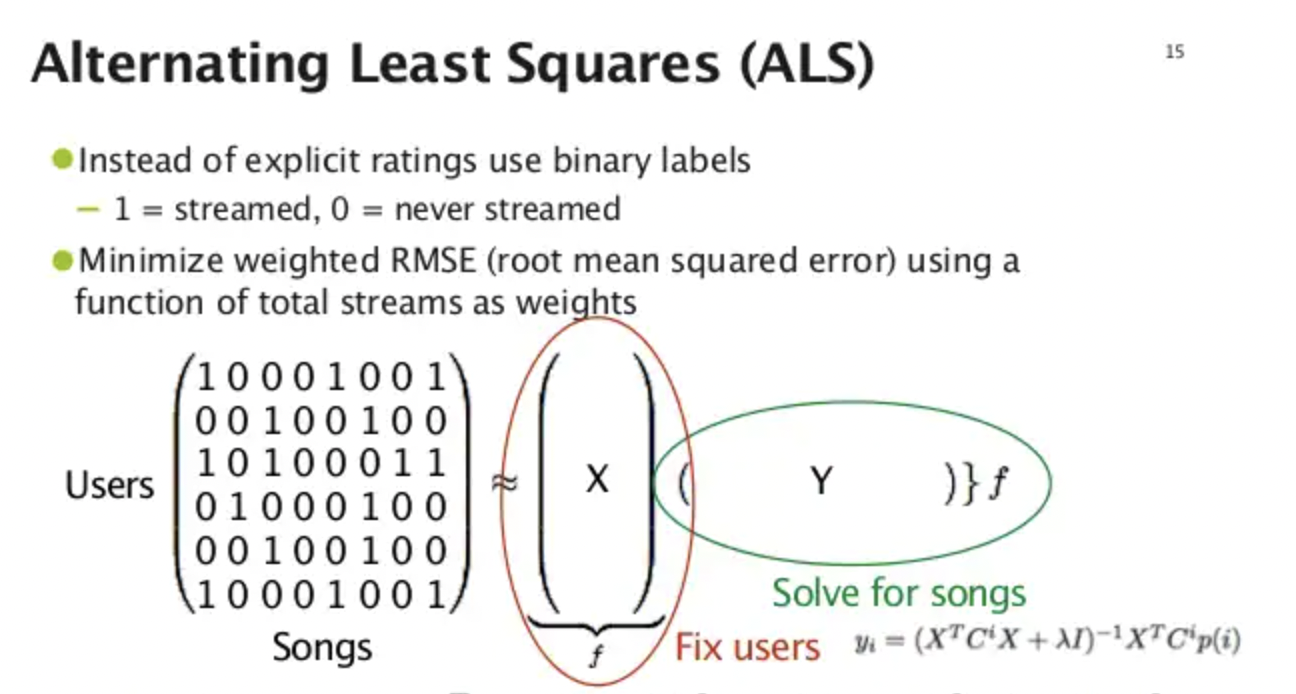

Для решения задачи за $U$ и $V$ можно было бы либо использовать SVD (что потребовало бы инвертирования потенциально очень большой матрицы и было бы очень дорогостоящим с точки зрения вычислений) для более точного решения факторизации, либо применить ALS для аппроксимации. В случае ALS, нам нужно решить только один функциональный вектор за раз, а это значит, что он может быть запущен параллельно. Для этого можно случайным образом инициализировать $U$ и решить за $V$. Затем мы можем вернуться назад и решить за $U$, используя наше решение за $V$. Продолжайте итерацию туда-сюда до тех пор, пока не получим сближение, максимально приближенное к $R$.

После этого мы можем просто взять точечное произведение в $U$ и $V$, чтобы посмотреть, какой будет прогнозируемый рейтинг для конкретного взаимодействия пользователя и элемента, даже если не было предыдущего взаимодействия. Эта базовая методология была принята Ху, Кореном и Волинским в работе [Collaborative Filtering for Implicit Feedback Datasets](http://yifanhu.net/PUB/cf.pdf) [Совместная фильтрация для неявных данных обратной связи](http://yifanhu.net/PUB/cf.pdf). Мы будем использовать метод этой статьи на реальном наборе данных и построим свою собственную систему рекомендаций.

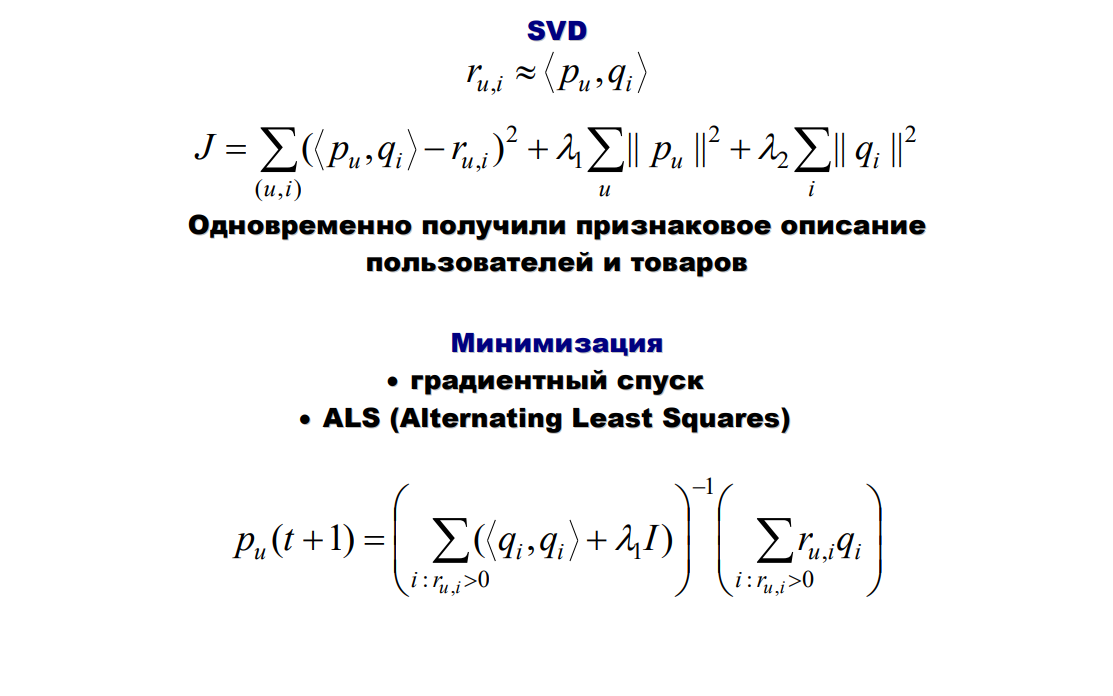

[Слайд взят из лекций Дьяконова](http://www.machinelearning.ru/wiki/images/0/0f/PZAD2017_11_recsys.pdf)

## Препроцессинг данных

Данные, которые мы используем для этого примера, поступают из репозитория UCI Machine Learning. Набор данных называется "Online Retail" и находится [здесь](http://archive.ics.uci.edu/ml/datasets/Online+Retail). Как видно из описания, в этом наборе данных содержатся все покупки, сделанные в компании, занимающейся розничной торговлей через Интернет, которая базируется в Великобритании в течение восьми месяцев.

Нам необходимо взять все транзакции для каждого клиента и поместить их в формат, который может использовать ALS. Это означает, что нам нужен каждый уникальный идентификатор клиента в строках матрицы, и каждый уникальный идентификатор товара в столбцах матрицы. Значения в матрице должны представлять собой общее количество покупок по каждой позиции по каждому клиенту.

Сначала загрузим несколько библиотек, которые помогут нам на этапе препроцессинга

In [1]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
from scipy.sparse.linalg import spsolve
import warnings
warnings.filterwarnings("ignore")

In [2]:
website_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
retail_data = pd.read_excel(website_url)
#retail_data = pd.read_excel('Online Retail.xlsx')

In [3]:
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Набор данных включает в себя номер счета-фактуры для различных покупок, а также StockCode (или ID товара), описание товара, номер приобретенного, дату покупки, цену товара, ID клиента и страну происхождения товара для клиента.

Проверим, нет ли в данных недостающих значений.

In [4]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Большинство столбцов не имеют пропущенных значений, но идентификатор клиента отсутствует в нескольких строках. Если ID клиента отсутствует, мы не знаем, кто купил товар. Сначала мы должны удалить эти строки из наших данных. Мы можем использовать pd.isnull для тестирования для строк с отсутствующими данными и только держать строки, которые имеют идентификатор клиента.

In [5]:
cleaned_retail = retail_data.loc[pd.isnull(retail_data.CustomerID) == False]

In [6]:
cleaned_retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


Намного лучше. Теперь у нас нет пропущенных значений, и все покупки могут быть сопоставлены с конкретным клиентом.

Прежде чем мы сделаем какую-либо матрицу рейтингов, было бы неплохо иметь таблицу поиска, в которой отслеживался бы идентификатор каждого товара вместе с его описанием. Давайте сделаем это сейчас.

In [7]:
item_lookup = cleaned_retail[['StockCode', 'Description']].drop_duplicates()
item_lookup['StockCode'] = item_lookup.StockCode.astype(str)

In [8]:
item_lookup.head()

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.


Это может сказать нам, что каждый предмет, например, StockCode 71053 - это белый металлический фонарь. Теперь, когда он создан, нам нужно:

- Групповое количество покупок вместе по коду склада и идентификатору товара
- Выкинуть фейковую транзакцию `POSTAGE`, соотвествующую печати чека и присутвующую во всех покупках
- Изменить любые суммы, равные нулю на единицу (это может произойти, если товар был возвращен, но мы хотим указать, что пользователь действительно приобрел товар, вместо того, чтобы предполагать, что взаимодействие между пользователем и товаром никогда не происходило).
- Включать только клиентов с положительным итогом покупки, чтобы исключить возможные ошибки.
- Настроить нашу матрицу разреженных рейтингов

Этот последний шаг особенно важен, если вы не хотите иметь ненужных проблем с памятью! Если подумать, то наша матрица будет содержать тысячи элементов и тысячи пользователей со значением "пользователь/элемент", необходимым для каждой возможной комбинации. Это БОЛЬШАЯ матрица, поэтому мы можем сэкономить много памяти, сохраняя только те места и значения элементов, которые не являются нулевыми.

Приведенный ниже код завершит шаги препроцессирования, необходимые для нашей матрицы с разреженными итоговыми рейтингами:

In [9]:
item_lookup[item_lookup.Description == 'POSTAGE']

,StockCode,Description
45,POST,POSTAGE


In [10]:
cleaned_retail = cleaned_retail[cleaned_retail['StockCode'] != 'POST']
cleaned_retail['CustomerID'] = cleaned_retail.CustomerID.astype(int)
cleaned_retail = cleaned_retail[['StockCode', 'Quantity', 'CustomerID']]
grouped_cleaned = cleaned_retail.groupby(['CustomerID', 'StockCode']).sum().reset_index()
grouped_cleaned.Quantity.loc[grouped_cleaned.Quantity == 0] = 1

grouped_purchased = grouped_cleaned.query('Quantity > 0')

In [11]:
grouped_purchased.head()

,CustomerID,StockCode,Quantity
0,12346,23166,1
1,12347,16008,24
2,12347,17021,36
3,12347,20665,6
4,12347,20719,40


In [12]:
grouped_purchased.StockCode.nunique()

3663

In [13]:
grouped_purchased.CustomerID.nunique()

4338

In [14]:
4338*3664

15894432

In [15]:
!pip install purl

Вместо того, чтобы представлять явный рейтинг, количество покупки может представлять собой "уверенность" в том, насколько сильным было взаимодействие. Товары с большим количеством покупок покупателя могут иметь больший вес в нашей рейтинговой матрице покупок.

Наш последний шаг - это создание матрицы разреженных рейтингов пользователей и товаров с помощью приведенного ниже кода:

In [16]:
customers = list(np.sort(grouped_purchased.CustomerID.unique()))
products = list(grouped_purchased.StockCode.unique())
quantity = list(grouped_purchased.Quantity)

rows = grouped_purchased.CustomerID.astype('category').cat.codes
cols = grouped_purchased.StockCode.astype('category').cat.codes
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(customers), len(products)))

In [17]:
purchases_sparse

<4338x3663 sparse matrix of type '<class 'numpy.int64'>'
	with 266392 stored elements in Compressed Sparse Row format>

У нас 4338 клиентов с 3664 товарами. Для этих взаимодействий между пользователями и элементами 266723 из них были приобретены. С точки зрения матрицы:

In [18]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

98.32353414649404

98,3% матрицы разреженно. Для того, чтобы фильтрация работала, разреженность должна быть меньше чем приблизительно 99.5%. Мы значительно ниже этого уровня, поэтому мы должны иметь возможность получить достойные результаты.

## Создание тренировочного и валидационного сета

In [19]:
import random
def make_train(ratings, pct_test = 0.2):

    test_set = ratings.copy()
    test_set[test_set != 0] = 1
    training_set = ratings.copy()
    nonzero_inds = training_set.nonzero()
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))
    random.seed(0)
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs)))
    samples = random.sample(nonzero_pairs, num_samples)
    user_inds = [index[0] for index in samples]
    item_inds = [index[1] for index in samples]
    training_set[user_inds, item_inds] = 0
    training_set.eliminate_zeros()
    return training_set, test_set, list(set(user_inds))

Это вернет наш набор для обучения, тестовый набор, который был бинаризован в 0/1 для купленных/не купленных, и список пользователей, у которых по крайней мере один пункт был замаскирован. Мы протестируем работу системы рекомендующих только на этих пользователях. В этом примере я маскирую 20% взаимодействия пользователя с элементом.

In [20]:
product_train, product_test, product_users_altered = make_train(purchases_sparse, pct_test = 0.2)

In [21]:
type(product_train)

scipy.sparse._csr.csr_matrix

In [22]:
product_train.shape

(4338, 3663)

##  ALS

In [26]:
!pip install implicit
#!apt install cuda
#!conda install -c conda-forge git+https://github.com/benfred/implicit.git@18a8010b07e8a86f8eb37f837b5bbda11647501f

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 21.3 MB/s eta 0:00:00


In [27]:
import implicit

**Caution: bag in new ALS version**

Обратите внимание, в новой версии `implicit.als.AlternatingLeastSquares` появила поддержка GPU по умолчанию. Однако она пока работает некорректно, и качество полученной модели может оказаться на уровне рандома. Поэтому для надежности использовать GPU не рекомендуется. Для этого необходимо в явном виде задать параметр `use_gpu = False`.

In [28]:
algo = implicit.als.AlternatingLeastSquares(factors = 32, regularization = 0.1, iterations =50, use_gpu=False)
algo.fit((product_train).astype('double'))

  0%|          | 0/50 [00:00<?, ?it/s]

В новой версии также надо быть аккуратнее в векторами для юзеров и для айтемов.


Вектора для юзеров:
```
user_vecs = algo.user_factors
```

Вектора для товаров:
```
item_vecs = algo.item_factors
```




In [41]:
user_vecs = algo.user_factors
item_vecs = algo.item_factors
# проверим по размерам, что мы действиельно не перепутали users и items
print(product_train.shape)
print(user_vecs.shape, item_vecs.shape)

(4338, 3663)
(4338, 32) (3663, 32)


In [42]:
user_vecs.dot(item_vecs.T).shape

(4338, 3663)

In [43]:
user_vecs[13,:].dot(item_vecs[2,:])

0.024689656

In [44]:
print(product_train.shape)

(4338, 3663)


## Оценка Системы

Мы отложили в тест 20% покупок. Это позволит нам оценить работу нашей системы рекомендаций. По сути, нам нужно посмотреть, соответствует ли порядок рекомендаций для каждого пользователя тем предметам, которые он в итоге приобрел. Часто используемой метрикой для такого рода проблем является область под кривой [Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (или ROC). Большая площадь под кривой означает, что мы рекомендуем товары, которые в конечном итоге были приобретены в верхней части списка рекомендуемых товаров. Обычно эта метрика используется в более типичных проблемах бинарной классификации для определения того, насколько хорошо модель может предсказать положительный пример по сравнению с отрицательным. Она также будет хорошо работать для наших целей ранжирования рекомендаций.

Для этого нам нужно написать функцию, которая может вычислить среднюю область под кривой (AUC) для любого пользователя, у которого хотя бы один элемент был замаскирован. В качестве эталона мы также вычислим, каким был бы средний AUC, если бы мы просто рекомендовали наиболее популярные элементы. Популярность, как правило, трудно превзойти в большинстве проблем рекомендательных систем, так что это - хороший baseline.

Во-первых, давайте сделаем простую функцию, которая может вычислить наш AUC. У Scikit-learn есть функция, которую мы можем немного изменить.

In [33]:
from sklearn import metrics
metrics.roc_curve?

In [34]:
metrics.auc?

In [35]:
def auc_score(predictions, test):

    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)

    return metrics.auc(fpr, tpr)

Теперь используем эту вспомогательную функцию внутри второй функции, которая будет вычислять AUC для каждого пользователя в нашем train наборе, у которого хотя бы один элемент был скрыт. Она также должна вычислить AUC для самых популярных элементов для сравнения наших пользователей.

In [36]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    Эта функция вычислит среднее значение AUC по пользователю для любого пользователя,
    у которого была изменена матрица пользовательского элемента.

    возвращает:

    Среднее AUC (область под кривой характеристик оператора приемника) тестового набора только по взаимодействию между пользователем и элементом.
    Изначально, в дополнение к наиболее популярным объектам в качестве эталона, было нулевым, чтобы протестировать способность ранжирования.
    '''

    store_auc = []
    popularity_auc = []
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1)
    item_vecs = predictions[1]
    for user in altered_users:
        training_row = training_set[user,:].toarray().reshape(-1)
        zero_inds = np.where(training_row == 0)
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)

        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1)

        pop = pop_items[zero_inds]
        store_auc.append(auc_score(pred, actual))
        popularity_auc.append(auc_score(pop, actual))

    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))

Теперь мы можем использовать эту функцию, чтобы посмотреть, как работает наша система рекомендаций. Чтобы использовать эту функцию, нам нужно будет преобразовать наш вывод из функции ALS в формат csr_matrix и переместить векторы элементов. Оригинальная чистая версия Python уже выводит векторы пользователя и элемента в правильном формате.

In [45]:
calc_mean_auc(product_train, product_users_altered,
              [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], product_test)

(0.85, 0.814)

Мы видим, что наша рекомендующая система побила baseline. Наша система имела средний AUC порядка 0.85, в то время как бенчмарк популярных позиций имел более низкий AUC 0.815. Вы можете вернуться назад и настроить гиперпараметры, если хотите посмотреть, сможете ли вы получить более высокий балл AUC. В идеале у вас должны быть отдельные наборы для train, перекрестной проверки и тестирования, чтобы вы не перегружались при настройке гиперпараметров, но эта настройка адекватна для демонстрации того, как проверить, что система работает.

## Пример

Теперь мы подготовили нашу систему рекомендаций и доказали, что она превосходит baseline. AUC 0.848 означает, что система рекомендует предметы, которые пользователь фактически приобрел в тестовом наборе гораздо чаще, чем предметы, которые пользователь никогда не покупал. Чтобы посмотреть на пример, как это работает, давайте рассмотрим рекомендации, данные конкретному пользователю, и примем субъективное решение, имеют ли они какой-то смысл.

Сначала, однако, нам нужно найти способ извлечь уже купленные пользователем в учебном наборе предметы. Сначала мы создадим массив наших клиентов и элементов, которые мы сделали ранее.

In [46]:
customers_arr = np.array(customers)
products_arr = np.array(products)

In [47]:
def get_items_purchased(customer_id, mf_train, customers_list, products_list, item_lookup):
    '''
    Функция дает информацию о том какие товары были куплены конкретным пользователем в тренировочном сете.

    возвращает:

    Лист ID товаров с описаниями, которые купил человек
    '''
    cust_ind = np.where(customers_list == customer_id)[0][0]
    purchased_ind = mf_train[cust_ind,:].nonzero()[1]
    prod_codes = products_list[purchased_ind]
    return item_lookup.loc[item_lookup.StockCode.isin(prod_codes)]

Нужно проверить это по ID клиента. Просмотрим список клиентов:

In [48]:
customers_arr[:5]

array([12346, 12347, 12348, 12349, 12350])

мы видим, что первый клиент в списке имеет ID 12346. Давайте рассмотрим их покупки из train набора.

In [49]:
get_items_purchased(12346, product_train, customers_arr, products_arr, item_lookup)

,StockCode,Description
4556,22264,FELT FARM ANIMAL WHITE BUNNY


In [50]:
from sklearn.preprocessing import MinMaxScaler

In [51]:
def rec_items(customer_id, mf_train, user_vecs, item_vecs, customer_list, item_list, item_lookup, num_items = 10):
    '''
    Функция возвращает топ рекомендаций юзерам

    параметры:

    customer_id - Customer_id для него рекомендуем

    mf_train - Тренировочная матрица

    user_vecs - user вектора матрицы

    item_vecs - item вектора матрицы

    customer_list - массив customer_id

    item_list - массив item

    item_lookup - проверка уникальности item/описания

    num_items - Количество предметов, выводящихся для рекомендаций. По умолчанию - 10.

    возвращает:

    Топ рекомендаций, выбранных на основании user/item векторов
    '''

    cust_ind = np.where(customer_list == customer_id)[0][0] # Возвращаем индекс строчки customer_id
    pref_vec = mf_train[cust_ind,:].toarray() # Берем рейтинги из тренировочного сета
    pref_vec = pref_vec.reshape(-1) + 1
    pref_vec[pref_vec > 1] = 0
    rec_vector = user_vecs[cust_ind,:].dot(item_vecs.T) # Произведение user вектора на item вектора
    # Шкалируем вектор между 0 и 1 (нормализация)
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    recommend_vector = pref_vec*rec_vector_scaled
    # Уже купленные товары умножаются на 0, чтобы их уже не рекомендовать
    product_idx = np.argsort(recommend_vector)[::-1][:num_items] # Сортировка лучших рекомендаций
    rec_list = []
    for index in product_idx:
        code = item_list[index]
        rec_list.append([code, item_lookup.Description.loc[item_lookup.StockCode == code].iloc[0]])
        # Добавляем описания в лист
    codes = [item[0] for item in rec_list]
    descriptions = [item[1] for item in rec_list]
    final_frame = pd.DataFrame({'StockCode': codes, 'Description': descriptions})
    return final_frame[['StockCode', 'Description']]

По сути, это позволит получить точечные продукты с наивысшим рейтингом в $N$ между нашими пользователями и товарными векторами для конкретного пользователя. Уже купленные товары не рекомендуются пользователю. Пока что давайте используем 10 пунктов по умолчанию и посмотрим, что система рекомендует выбрать для нашего пользователя.

In [52]:
rec_items(12346, product_train, user_vecs, item_vecs, customers_arr, products_arr, item_lookup,
                       num_items = 10)

,StockCode,Description
0,22529,MAGIC DRAWING SLATE GO TO THE FAIR
1,22258,FELT FARM ANIMAL RABBIT
2,22393,PAPERWEIGHT VINTAGE COLLAGE
3,85141,JARDIN ETCHED GLASS FRUITBOWL
4,84678,CLASSICAL ROSE SMALL VASE
5,22425,ENAMEL COLANDER CREAM
6,21819,GLITTER CHRISTMAS STAR
7,22319,HAIRCLIPS FORTIES FABRIC ASSORTED
8,22426,ENAMEL WASH BOWL CREAM
9,22694,WICKER STAR


Эти рекомендации кажутся довольно хорошими!

Давайте попробуем другого пользователя, который не сделал большого количества покупок:

In [53]:
get_items_purchased(12361, product_train, customers_arr, products_arr, item_lookup)

,StockCode,Description
91,84997C,BLUE 3 PIECE POLKADOT CUTLERY SET
1203,21179,NO JUNK MAIL METAL SIGN
95267,84997C,CHILDRENS CUTLERY POLKADOT BLUE
311445,23445,ICE CREAM BUBBLES
354136,23512,EMBROIDERED RIBBON REEL ROSIE


In [54]:
rec_items(12361, product_train, user_vecs, item_vecs, customers_arr, products_arr, item_lookup,
                       num_items = 10)

,StockCode,Description
0,84997D,PINK 3 PIECE POLKADOT CUTLERY SET
1,23360,SET 8 CANDLES VINTAGE DOILEY
2,22222,CAKE PLATE LOVEBIRD WHITE
3,23436,GIFT BAG LARGE VINTAGE CHRISTMAS
4,23513,EMBROIDERED RIBBON REEL SUSIE
5,85232D,SET/3 DECOUPAGE STACKING TINS
6,85167B,BLACK GRAND BAROQUE PHOTO FRAME
7,21084,SET/6 COLLAGE PAPER CUPS
8,21137,BLACK RECORD COVER FRAME
9,21191,LARGE WHITE HONEYCOMB PAPER BELL


## Дргугие подходы Подходы

1) Коллаборативная фильтрация

2) Content-based

3) Гибридный подход

### Content Based (Pandora)

В случае с Pandora, онлайновой компанией, занимающейся потоковой музыкой, они решили инжиниринговать возможности из всех песен в своем каталоге в рамках [Music Genome Project](https://en.wikipedia.org/wiki/Music_Genome_Project). Большинство песен основаны на векторе характеристик (450 фичей), которые были получены в результате очень продолжительного препроцессинга. Как только вы получите этот набор фичей, одна из техник, которая работает достаточно хорошо, заключается в том, чтобы трактовать проблему рекомендации как проблему бинарной классификации. Это позволяет использовать более традиционные методы машинного обучения, которые выводят вероятность того, что определенному пользователю понравится конкретная песня, основанная на тренировочном наборе истории прослушивания его песни. Затем, просто порекомендуйте песни с наибольшей вероятностью понравиться.

В большинстве случаев, однако, у вас не будет функций, уже закодированных для всех ваших продуктов. Это будет очень сложно, и Pandora потратила несколько лет на то, чтобы закончить свою систему рекоммендаций.

### Демография (Facebook)

 Если у вас есть много демографической информации о ваших пользователях, как у Facebook или LinkedIn, вы можете рекомендовывать, основываясь на похожих пользователях и их прошлом поведении. Подобно методу, основанному на контенте, вы можете вывести функциональный вектор для каждого из ваших пользователей и сгенерировать модели, предсказывающие вероятность того, что вам понравятся определенные элементы.

Опять же, для этого требуется много информации о ваших пользователях, которой у вас, вероятно, нет в большинстве случаев.

Поэтому, если вам нужен метод, который не заботится о подробной информации о ваших элементах или ваших пользователях, collaborative filtering - это очень мощный метод, который работает с высокой эффективностью.